## load数据

In [2]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
from matplotlib.pylab import rcParams
print(os.listdir("D:/program/Cargo_forecast/dot_data_all/"))
rcParams['figure.figsize'] = 16, 4

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'comments.txt', 'test.csv']


In [4]:
path = "D:/program/Cargo_forecast/dot_data_all/"
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [3]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)

NameError: name 'dot_data_1' is not defined

In [4]:
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)
data.head()

,dot,order_date,order_num
0,13825092291,2017-05-23,1
1,15102680258,2017-06-06,1
2,ERP客户系统组,2017-06-09,1
3,IT采购组,2017-04-13,8
4,IT采购组,2017-05-03,4


In [6]:
data_ts = data.copy()
data_ts.index = data['order_date']
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [7]:
data_ts.sort_index(ascending = True, inplace = True)
data_ts.head()

,dot,order_date,order_num
order_date,,,
2011-01-03,深圳公明点部,2011-01-03,1
2011-01-04,苏州操作部,2011-01-04,1
2011-01-05,苏州常州点部,2011-01-05,1
2011-01-05,深圳操作部,2011-01-05,2
2011-01-08,深圳操作部,2011-01-08,1


In [13]:
tmp = data_ts['2017-11':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-11-01,松江新桥点部,2017-11-01,113
2017-11-01,成都公兴点部,2017-11-01,3
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,海口龙华点部,2017-11-01,5
2017-11-01,温州娄桥点部,2017-11-01,110


In [14]:
tmp['order_date'].groupby(tmp['dot']).count().head()

dot
ERP客户系统组    4
ERP解答组      1
ERP调度配载组    1
IT南山中心组     1
IT运维组       1
Name: order_date, dtype: int64

In [16]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
data_count.head()

,dot,order_date
0,ERP客户系统组,4
1,ERP解答组,1
2,ERP调度配载组,1
3,IT南山中心组,1
4,IT运维组,1


In [17]:
useful_dot_name = data_count.loc[data_count['order_date'] >= 360, ['dot']]
useful_dot_name.head()

,dot
31,上虞上浦点部
32,上虞东关点部
36,上虞小越点部
38,上虞崧厦点部
58,东丽中心庄点部


In [18]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]

,dot,order_date,order_num
order_date,,,
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,温州娄桥点部,2017-11-01,110
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-01,惠山玉祁点部,2017-11-01,31
2017-11-01,金陵光华门点部,2017-11-01,8


In [21]:
result_data.head(10)

,dot,order_date,order_num
order_date,,,
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,温州娄桥点部,2017-11-01,110
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-01,惠山玉祁点部,2017-11-01,31
2017-11-01,金陵光华门点部,2017-11-01,8
2017-11-01,寮步华为点部,2017-11-01,24
2017-11-01,南通启东点部,2017-11-01,92
2017-11-01,青岛崂山点部,2017-11-01,12
2017-11-01,大朗二级装卸组,2017-11-01,42


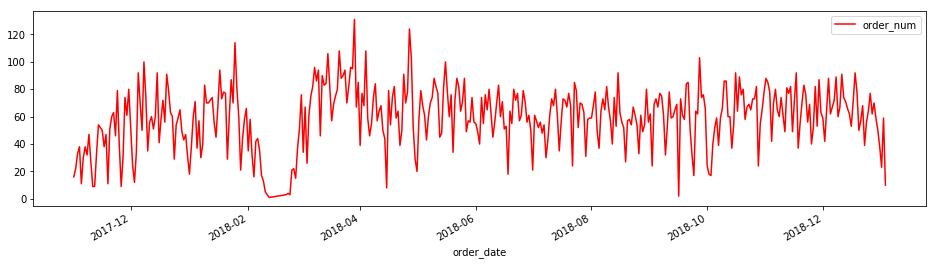

In [24]:
(result_data.loc[result_data['dot'] == '寮步凫山点部', ['order_date', 'order_num']]
.plot(x = 'order_date', y = 'order_num', figsize = (16,4), color = 'r'))   # , xlim = ['2018-08-01', '2018-10-30']

In [27]:
result_data.loc[result_data['dot'] == '寮步凫山点部'].head()

,dot,order_date,order_num
order_date,,,
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-02,寮步凫山点部,2017-11-02,22
2017-11-03,寮步凫山点部,2017-11-03,33
2017-11-04,寮步凫山点部,2017-11-04,38
2017-11-05,寮步凫山点部,2017-11-05,11


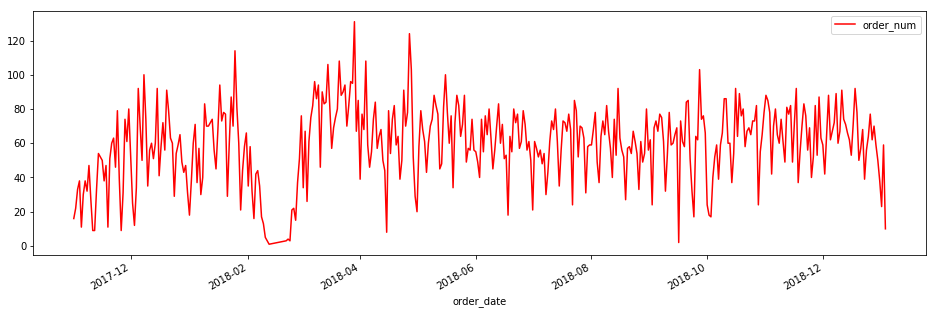

In [215]:
result_ts = result_data.loc[result_data['dot'] == '寮步凫山点部', ['order_num']]
result_ts.plot(figsize = (16,5), color = 'r')

In [228]:
# result_ts = result_ts['order_num'].resample('D').sum()
result_ts = result_ts['order_num'].resample('W-MON').sum()

KeyError: 'order_num'

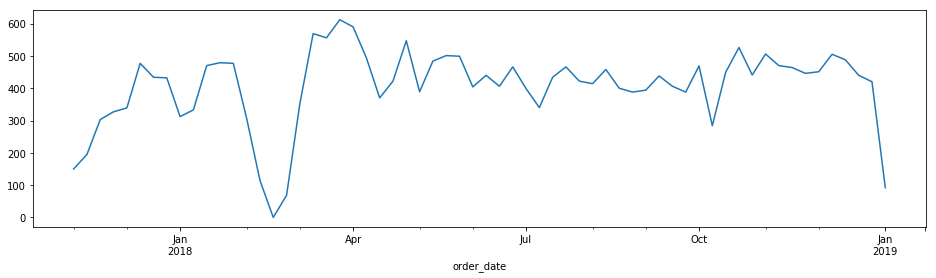

In [229]:
result_ts.plot()

In [217]:
dftest = adfuller(result_ts)
output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistic                 -4.102436
p-value                         0.000960
#Lags Used                      1.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64

In [218]:
lag_acf = acf(result_ts, nlags = 30)
lag_pacf = pacf(result_ts, nlags = 30)

Text(0.5,1,'Partial Autocorrelation Function')

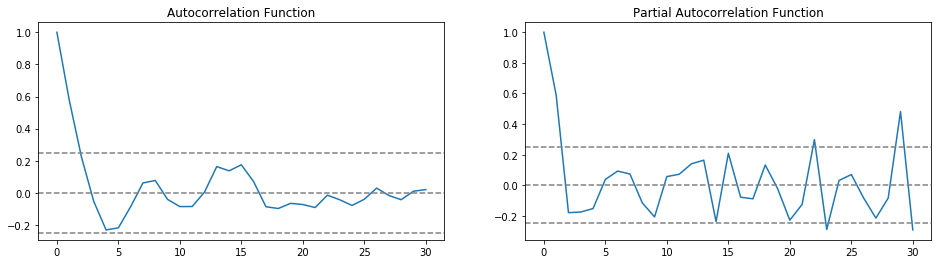

In [219]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(result_ts)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(result_ts)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(result_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(result_ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


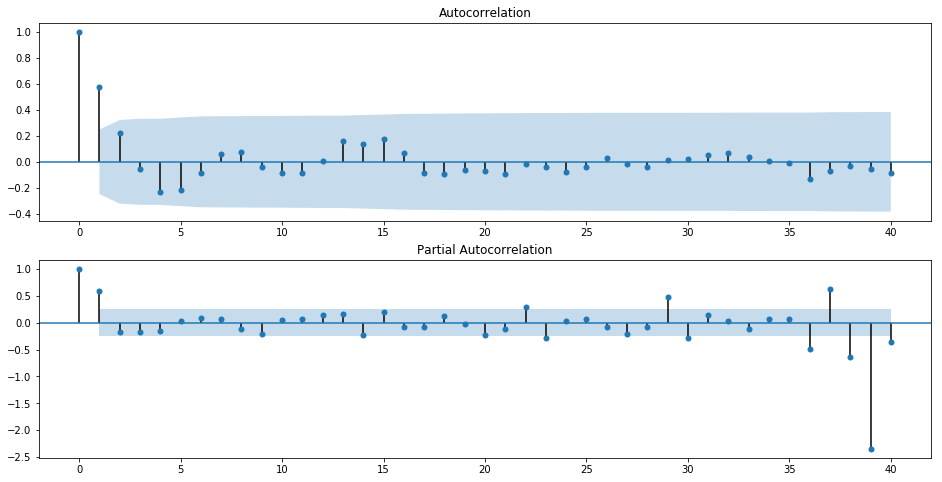

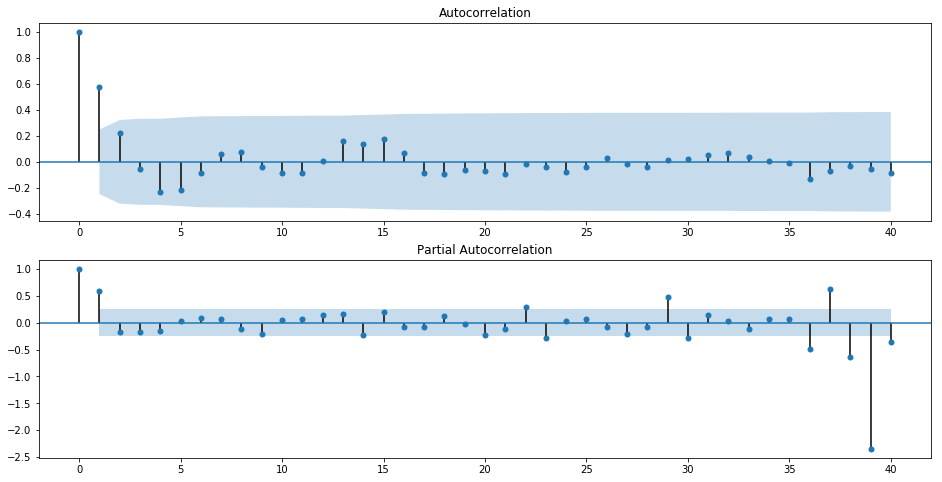

In [220]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(211)
plot_acf(result_ts, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
plot_pacf(result_ts, lags = 40, ax = ax2)

In [222]:
result_ts[58 : ]

order_date
2018-12-17    488
2018-12-24    440
2018-12-31    420
2019-01-07     92
Freq: W-MON, Name: order_num, dtype: int64

In [223]:
# result_ts_train = result_ts[ : -(2*30)]
# result_ts_test = result_ts[-(2*30) : ]
result_ts_train = result_ts[ : 58]
result_ts_test = result_ts[58 : ]

In [224]:
result_ts_train.head().append(result_ts_train.tail())

order_date
2017-11-06    150
2017-11-13    195
2017-11-20    303
2017-11-27    327
2017-12-04    339
2018-11-12    470
2018-11-19    464
2018-11-26    446
2018-12-03    451
2018-12-10    505
Name: order_num, dtype: int64

In [225]:
arma_model = ARMA(result_ts_train, order = (1, 1)).fit()
arma_model.aic,arma_model.bic,arma_model.hqic

(686.7801815002219, 695.0219535424076, 689.9905181686945)

In [226]:
arma_result = arma_model.predict()

Text(0.5,1,'RSME : 86.9668')

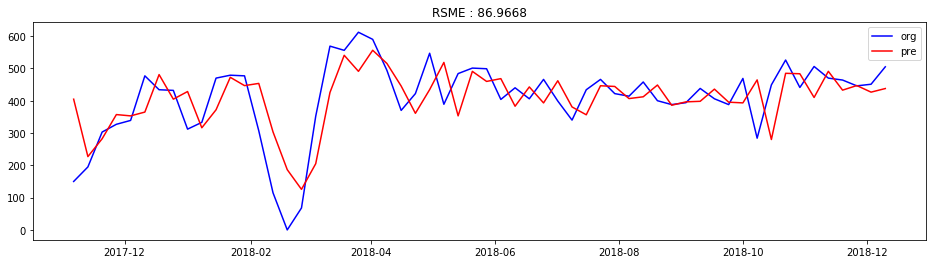

In [230]:
plt.plot(result_ts_train, label = 'org', color = 'b')
plt.plot(arma_result, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("RSME : %.4f" % np.sqrt(np.sum((arma_result - result_ts_train) ** 2)/len(result_ts_train)))

In [236]:
test_result = pd.Series(arma_model.forecast(4)[0], index = result_ts_test.index)

329.69091071110734

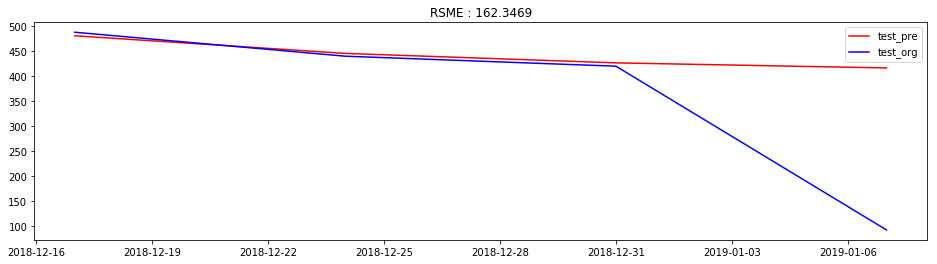

In [243]:
plt.plot(test_result, label = 'test_pre', color = 'r')
plt.plot(result_ts_test, label = 'test_org', color = 'b')
plt.legend(loc = 'best')
plt.title("RSME : %.4f" % np.sqrt(np.sum((result_ts_test - test_result) ** 2)/len(test_result)))
np.sum(test_result - result_ts_test)

In [241]:
for i in range(len(test_result)):
    print(min(test_result[i], result_ts_test[i])/max(test_result[i], result_ts_test[i]))

0.9855252969483155
0.9874355264819895
0.9844010512082418
0.22088810225346883
